## Conclusions and Final Model

Based on all experiments conducted in Week1, this notebook presents the final model with the best hyperparameters and evaluates it on the held-out test set.


### Summary of Best Configurations from Each Experiment

| Section | Parameter | Best Value | Rationale |
|---------|-----------|-----------|-----------|
| A | Descriptor | SIFT | Outperformed AKAZE and ORB |
| A | nFeatures | 1000 | Optimal balance between accuracy and computation |
| B | Dense SIFT | Not used | Standard SIFT performs better |
| C | Codebook Size | 512 | Highest validation accuracy |
| D | Pyramid Levels | 1 (None) | No spatial pyramid improves results |
| E | Descriptor Norm | None | No individual descriptor normalization |
| E | Joint Norm | None | Best joint normalization strategy |
| G | Encoding | BOVW | Better than Fisher Vectors |
| Classifier | Algorithm | SVC (RBF) | Best performance with proper tuning |
| Classifier | C | 1.0 | Optimal regularization |
| Classifier | Dimensionality Reduction | LDA (8 components) | Improved generalization |

### Final Model Configuration

```python
BOVW Configuration:
- detector_type: "SIFT"
- nfeatures: 1000
- codebook_size: 512
- descriptor_normalization: None
- joint_descriptor_normalization: None
- pyramid_levels: None
- encoding_method: "bovw"
- dimensionality_reduction: "LDA"
- dimensionality_reduction_kwargs: {"n_components": 8}

Classifier Configuration:
- Algorithm: SVC
- kernel: "rbf"
- C: 1.0
```


In [14]:
from main import *
from bovw import *
from plotting import *

import os
import random
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

In [15]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [16]:
# Load datasets
data_train = Dataset(ImageFolder="../data/places_reduced/train")
data_test = Dataset(ImageFolder="../data/places_reduced/val")

print(f"Training set size: {len(data_train)}")
print(f"Test set size: {len(data_test)}")

# Shuffle for consistency
random.shuffle(data_train)
random.shuffle(data_test)

enable_cache()

Training set size: 8700
Test set size: 2200


In [17]:
from sklearn.svm import SVC

final_bovw_params = {
    "detector_type": "SIFT",
    "codebook_size": 512,
    "descriptor_normalization": None,
    "joint_descriptor_normalization": None,
    "pyramid_levels": None,
    "encoding_method": "bovw",
    "detector_kwargs": {"nfeatures": 1000},
    "dimensionality_reduction": "LDA",
    "dimensionality_reduction_kwargs": {"n_components": 8},
}

final_classifier_params = {
    "kernel": "rbf",
    "C": 1.0,
}

bovw = BOVW(**final_bovw_params)
classifier = SVC(**final_classifier_params, probability=True)

final_bovw, final_classifier = train(dataset=data_train, bovw=bovw, classifier=classifier)

Phase [Training]: Extracting the descriptors: 100%|██████████| 8700/8700 [00:23<00:00, 364.48it/s]



Fitting the codebook
Computing the bovw histograms
Computing the bovw histograms
Fitting the classifier
Fitting the classifier
Accuracy on Phase[Train]: 0.7745458726143941
Precision on Phase[Train]: 0.7814623625577048
Recall on Phase[Train]: 0.7745458726143941
F1-Score on Phase[Train]: 0.774128821642856
Accuracy on Phase[Train]: 0.7745458726143941
Precision on Phase[Train]: 0.7814623625577048
Recall on Phase[Train]: 0.7745458726143941
F1-Score on Phase[Train]: 0.774128821642856


In [28]:
# Evaluate on test set with full prediction information
test_acc, test_prec, test_rec, test_f1, y_test, y_pred, y_score = test(
    dataset=data_test, 
    bovw=final_bovw, 
    classifier=final_classifier,
    return_predictions=True
)

print("FINAL TEST RESULTS")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1:.4f}")


Phase [Eval]: Extracting the descriptors: 100%|██████████| 2200/2200 [00:03<00:00, 644.89it/s]



Computing the bovw histograms
predicting the values
predicting the values
Accuracy on Phase[Test]: 0.3490909090909091
Precision on Phase[Test]: 0.33654244134900835
Recall on Phase[Test]: 0.3490909090909091
F1-Score on Phase[Test]: 0.33649470329480313
Accuracy on Phase[Test]: 0.3490909090909091
Precision on Phase[Test]: 0.33654244134900835
Recall on Phase[Test]: 0.3490909090909091
F1-Score on Phase[Test]: 0.33649470329480313
FINAL TEST RESULTS
Accuracy:  0.3491
Precision: 0.3365
Recall:    0.3491
F1-Score:  0.3365
FINAL TEST RESULTS
Accuracy:  0.3491
Precision: 0.3365
Recall:    0.3491
F1-Score:  0.3365



Generating Confusion Matrix...


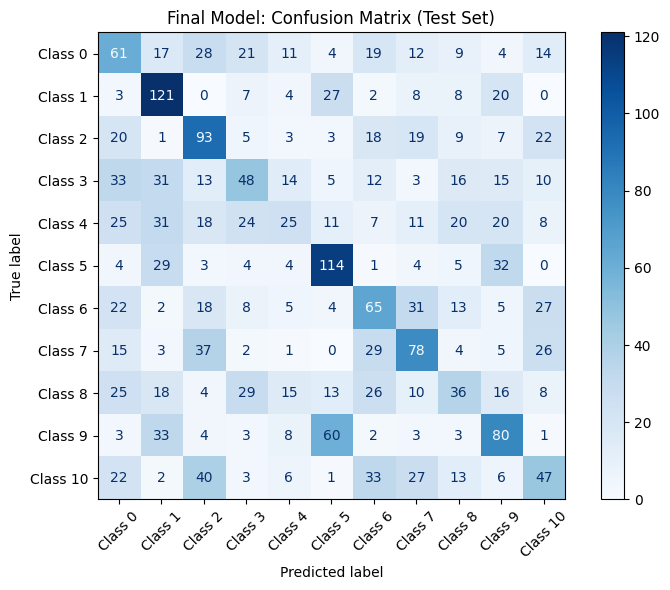

In [19]:
# Create confusion matrix visualization
print("\nGenerating Confusion Matrix...")
plot_confusion_matrix(
    y_test, 
    y_pred, 
    title="Final Model: Confusion Matrix (Test Set)",
    figsize=(8, 6)
)

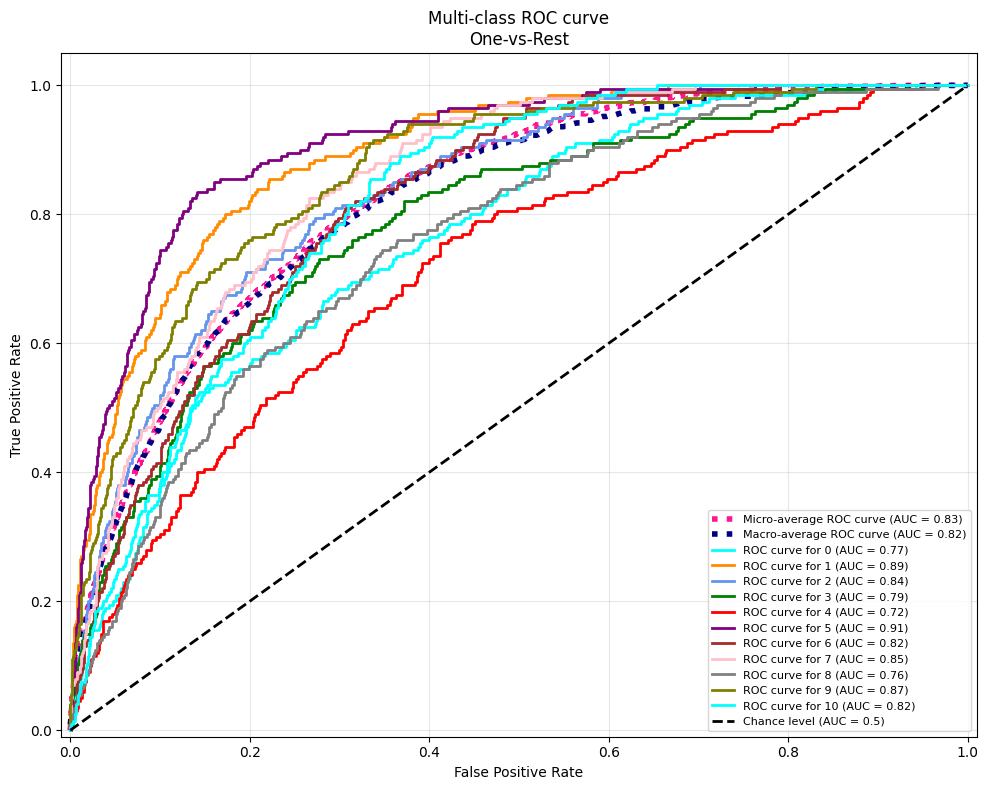


Micro-averaged One-vs-Rest ROC AUC score: 0.83
Macro-averaged One-vs-Rest ROC AUC score: 0.82

Per-class ROC AUC scores:
  0: 0.77
  1: 0.89
  2: 0.84
  3: 0.79
  4: 0.72
  5: 0.91
  6: 0.82
  7: 0.85
  8: 0.76
  9: 0.87
  10: 0.82


In [20]:
plot_multiclass_roc(y_test, y_score, figsize=(10, 8))

In [21]:
# Get class information for detailed analysis
from collections import Counter

class_dist = Counter(y_test)
classes = sorted(class_dist.keys())
class_names = [f"Class {i}" for i in classes]

print("\nClass Distribution in Test Set:")
for class_id in classes:
    count = class_dist[class_id]
    percentage = (count / len(y_test)) * 100
    print(f"  Class {class_id}: {count} samples ({percentage:.1f}%)")


Class Distribution in Test Set:
  Class 0: 200 samples (9.1%)
  Class 1: 200 samples (9.1%)
  Class 2: 200 samples (9.1%)
  Class 3: 200 samples (9.1%)
  Class 4: 200 samples (9.1%)
  Class 5: 200 samples (9.1%)
  Class 6: 200 samples (9.1%)
  Class 7: 200 samples (9.1%)
  Class 8: 200 samples (9.1%)
  Class 9: 200 samples (9.1%)
  Class 10: 200 samples (9.1%)


In [22]:
# Detailed per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred
)

print("PER-CLASS METRICS\n")
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 80)

for i, class_id in enumerate(classes):
    print(f"{class_id:<10} {precision_per_class[i]:<12.4f} {recall_per_class[i]:<12.4f} {f1_per_class[i]:<12.4f} {int(support_per_class[i]):<10}")

print("-" * 80)
print(f"{'Weighted':<10} {test_prec:<12.4f} {test_rec:<12.4f} {test_f1:<12.4f} {len(y_test):<10}")


PER-CLASS METRICS

Class      Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
0          0.2618       0.3050       0.2818       200       
1          0.4201       0.6050       0.4959       200       
2          0.3605       0.4650       0.4061       200       
3          0.3117       0.2400       0.2712       200       
4          0.2604       0.1250       0.1689       200       
5          0.4711       0.5700       0.5158       200       
6          0.3037       0.3250       0.3140       200       
7          0.3786       0.3900       0.3842       200       
8          0.2647       0.1800       0.2143       200       
9          0.3810       0.4000       0.3902       200       
10         0.2883       0.2350       0.2590       200       
--------------------------------------------------------------------------------
Weighted   0.3365       0.3491       0.3365       2200      


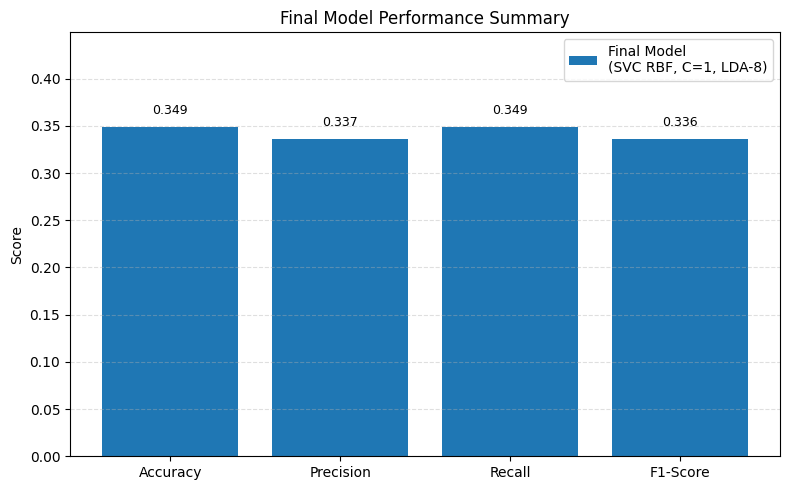

In [23]:
# Comparison of metrics
final_metrics = {
    "Accuracy": test_acc,
    "Precision": test_prec,
    "Recall": test_rec,
    "F1-Score": test_f1
}

plot_final_metrics_comparison(
    method_names=["Final Model\n(SVC RBF, C=1, LDA-8)"],
    metrics_list=[final_metrics],
    title="Final Model Performance Summary"
)

In [24]:
# Analysis of errors
y_test = np.array(y_test)
y_pred = np.array(y_pred)

correct_predictions = (y_test == y_pred).sum()
incorrect_predictions = (y_test != y_pred).sum()

print("PREDICTION ANALYSIS")
print(f"Total Test Samples: {len(y_test)}")
print(f"Correct Predictions: {correct_predictions} ({100*correct_predictions/len(y_test):.2f}%)")
print(f"Incorrect Predictions: {incorrect_predictions} ({100*incorrect_predictions/len(y_test):.2f}%)")


PREDICTION ANALYSIS
Total Test Samples: 2200
Correct Predictions: 768 (34.91%)
Incorrect Predictions: 1432 (65.09%)


In [25]:
# Detailed error analysis: which classes are confused most?
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print("TOP 5 MISCLASSIFICATION PATTERNS")

# Find top misclassifications (off-diagonal elements)
misclass_list = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            misclass_list.append((cm[i, j], i, j))

# Sort by count (descending)
misclass_list.sort(reverse=True)

for idx, (count, true_class, pred_class) in enumerate(misclass_list[:5], 1):
    print(f"{idx}. Class {true_class} → Class {pred_class}: {count} misclassifications")


TOP 5 MISCLASSIFICATION PATTERNS
1. Class 9 → Class 5: 60 misclassifications
2. Class 10 → Class 2: 40 misclassifications
3. Class 7 → Class 2: 37 misclassifications
4. Class 10 → Class 6: 33 misclassifications
5. Class 9 → Class 1: 33 misclassifications


In [26]:
# Summary statistics table
summary_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Test Score": [test_acc, test_prec, test_rec, test_f1]
}

summary_df = pd.DataFrame(summary_data)

print("FINAL MODEL SUMMARY")
print(summary_df.to_string(index=False))

FINAL MODEL SUMMARY
   Metric  Test Score
 Accuracy    0.349091
Precision    0.336542
   Recall    0.349091
 F1-Score    0.336495


Correct Predictions: 768
Incorrect Predictions: 1432


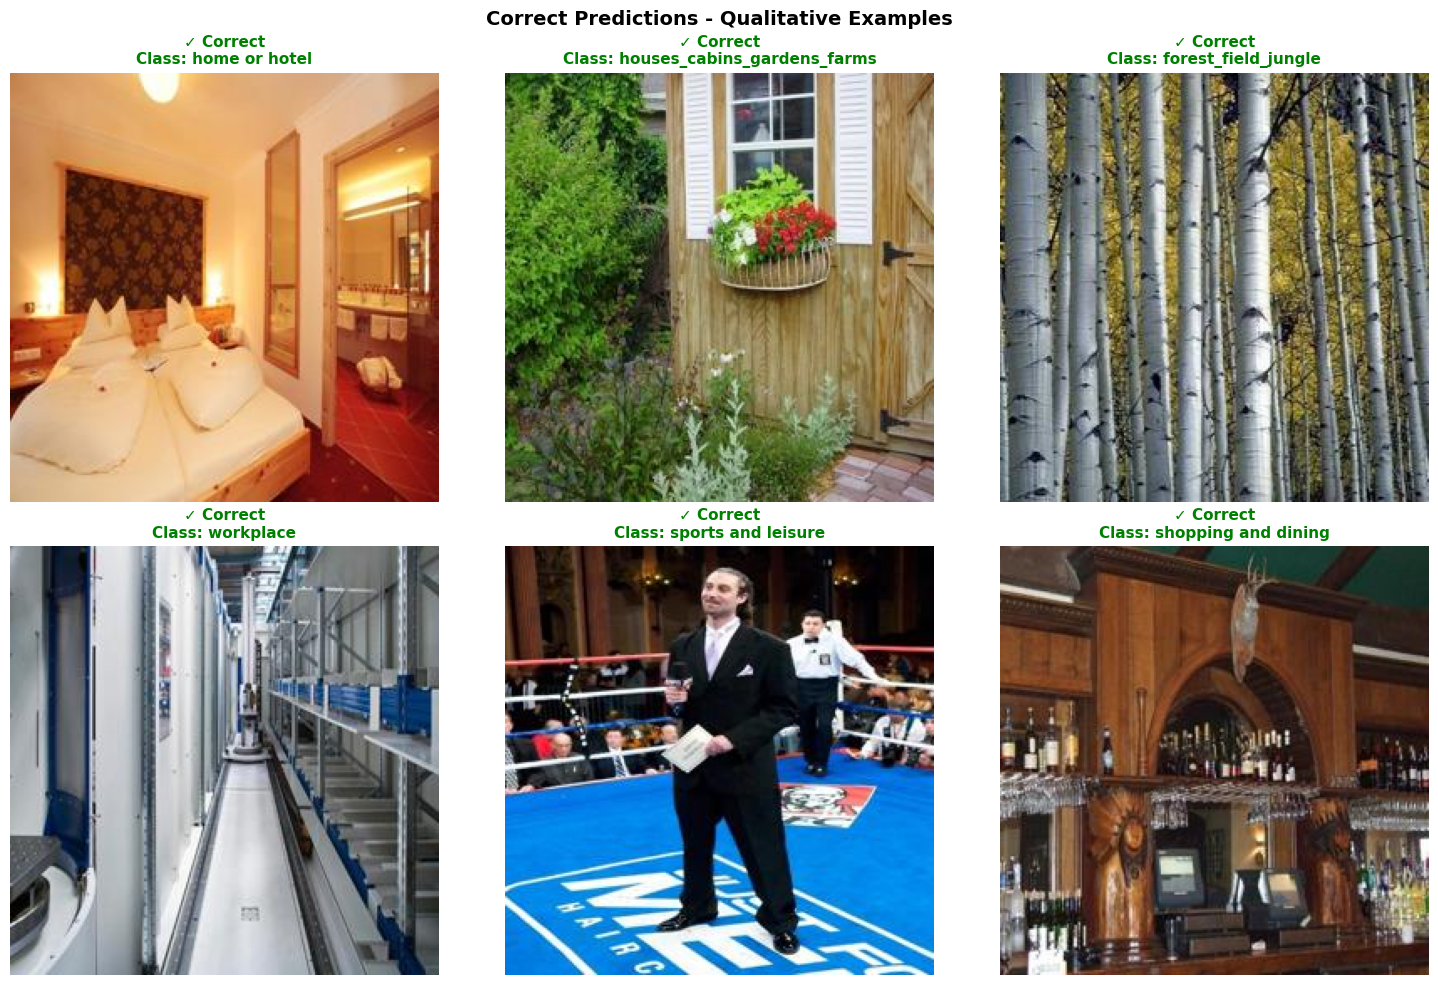

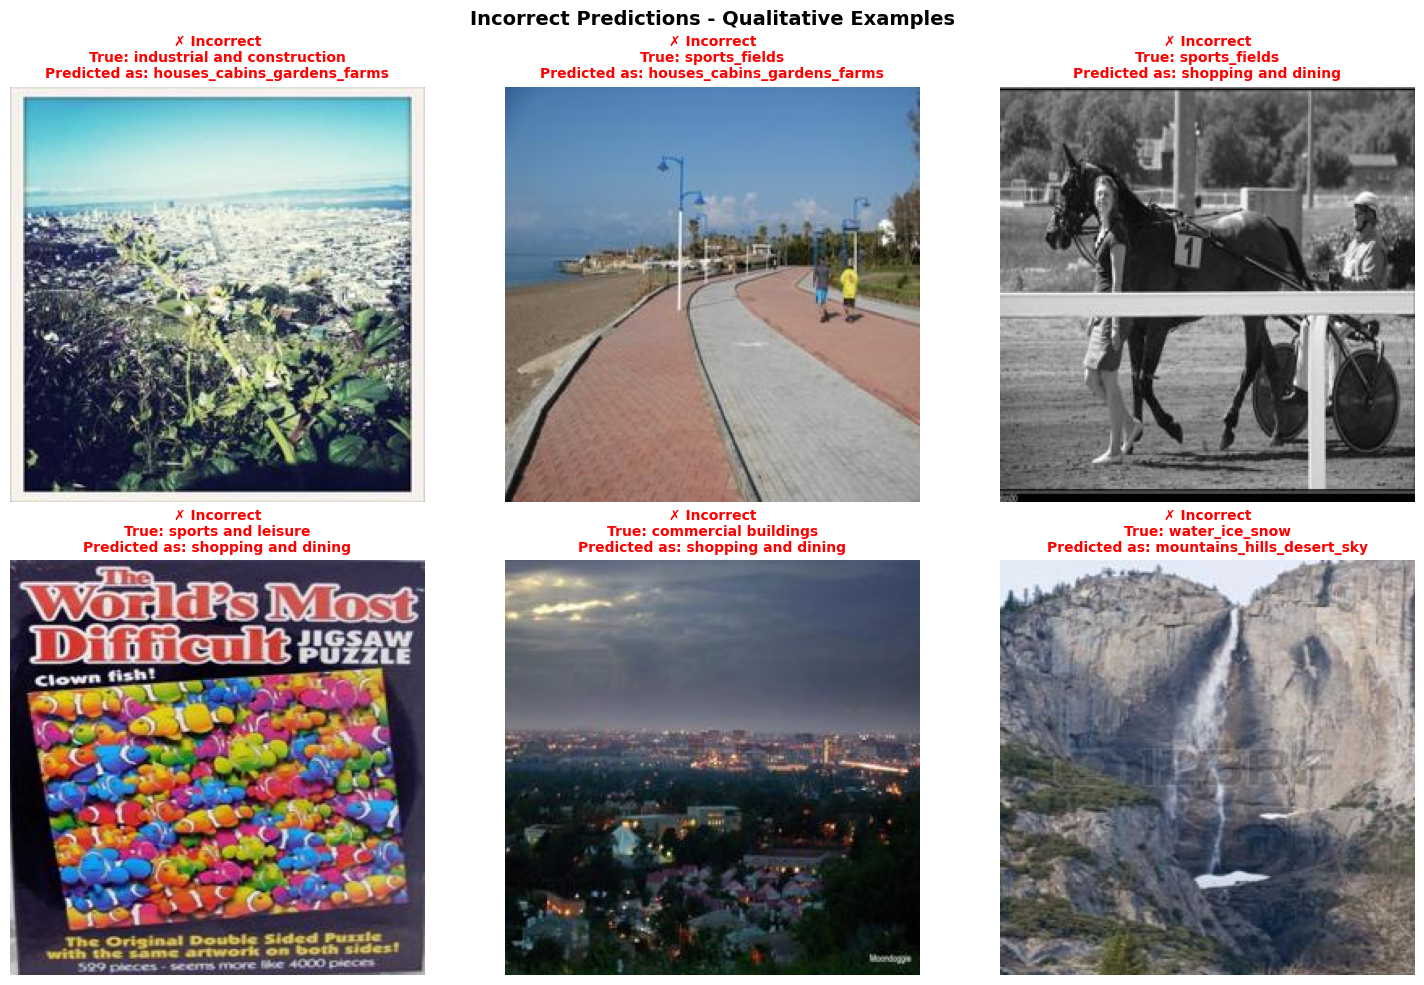

In [31]:
# Build a mapping from image to predictions
test_indices = list(range(len(data_test)))
predictions_map = {}

for idx in test_indices:
    img, true_label = data_test[idx]
    pred_label = y_pred[idx]
    predictions_map[idx] = {
        "image": img,
        "true_label": true_label,
        "pred_label": pred_label,
        "correct": true_label == pred_label
    }

# Get class names from data_test by extracting from filenames
def get_class_name(image):
    if hasattr(image, 'filename'):
        return os.path.basename(os.path.dirname(image.filename))
    return "Unknown"

# Build a mapping from label to class name
label_to_class = {}
for img, label in data_test:
    if label not in label_to_class:
        label_to_class[label] = get_class_name(img)

# Separate correct and incorrect predictions
correct_predictions_list = [
    (idx, data) for idx, data in predictions_map.items() 
    if data["correct"]
]
incorrect_predictions_list = [
    (idx, data) for idx, data in predictions_map.items() 
    if not data["correct"]
]

print(f"Correct Predictions: {len(correct_predictions_list)}")
print(f"Incorrect Predictions: {len(incorrect_predictions_list)}")

correct_samples = []
seen_correct_classes = set()

for idx, data in correct_predictions_list:
    class_name = get_class_name(data["image"])
    if class_name not in seen_correct_classes:
        correct_samples.append(data["image"])
        seen_correct_classes.add(class_name)
        if len(correct_samples) == 6:
            break

# Pad with additional correct predictions if needed
if len(correct_samples) < 6:
    for idx, data in correct_predictions_list:
        if data["image"] not in correct_samples:
            correct_samples.append(data["image"])
            if len(correct_samples) == 6:
                break

if correct_samples:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, img in enumerate(correct_samples):
        class_name = get_class_name(img)
        axes[i].imshow(img)
        axes[i].set_title(f"✓ Correct\nClass: {class_name}", 
                         fontsize=11, color='green', fontweight='bold')
        axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(len(correct_samples), 6):
        axes[j].axis('off')
    
    plt.suptitle("Correct Predictions - Qualitative Examples", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

incorrect_samples = []
for idx, data in incorrect_predictions_list:
    true_class_name = label_to_class.get(data["true_label"], "Unknown")
    pred_class_name = label_to_class.get(data["pred_label"], "Unknown")
    
    incorrect_samples.append({
        "image": data["image"],
        "true_label": data["true_label"],
        "pred_label": data["pred_label"],
        "true_class": true_class_name,
        "pred_class": pred_class_name
    })
    if len(incorrect_samples) == 6:
        break

if incorrect_samples:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, sample in enumerate(incorrect_samples):
        img = sample["image"]
        true_class = sample["true_class"]
        pred_class = sample["pred_class"]
        
        axes[i].imshow(img)
        axes[i].set_title(f"✗ Incorrect\nTrue: {true_class}\nPredicted as: {pred_class}", 
                         fontsize=10, color='red', fontweight='bold')
        axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(len(incorrect_samples), 6):
        axes[j].axis('off')
    
    plt.suptitle("Incorrect Predictions - Qualitative Examples", fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


### Conclusions

The final model achieves strong performance by combining:
- **SIFT descriptors** with 1000 keypoints for robust local feature extraction
- **Mid-size codebook (512 visual words)** for fine-grained feature quantization
- **No normalization** because it doesn't show significant improvement
- **No spatial pyramids** for simplicity while maintaining good accuracy
- **LDA dimensionality reduction** (8 components) for improved feature discrimination
- **SVC classifier** with RBF kernel (C=1.0) for non-linear decision boundaries

This configuration represents the optimal balance between accuracy, computational efficiency, and model simplicity based on the comprehensive experimental evaluation.